In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv("./data/final_data/X_train.csv", encoding='utf-8')
X_test = pd.read_csv("./data/final_data/X_test.csv", encoding='utf-8')
y_train = pd.read_csv("./data/final_data/y_train.csv", encoding='utf-8')
y_test = pd.read_csv("./data/final_data/y_test.csv", encoding='utf-8')

In [3]:
X_train = X_train.rename(columns={"team_won_finals": "team_won_nba_finals"})
X_train = X_train.rename(columns={"team_lost_finals": "team_lost_nba_finals"})
X_train = X_train.rename(columns={"team_lost_semifinals": "team_lost_conf_finals"})
X_train = X_train.rename(columns={"team_lost_first_match": "team_exit_before_conf_finals"})
X_test = X_test.rename(columns={"team_won_finals": "team_won_nba_finals"})
X_test = X_test.rename(columns={"team_lost_finals": "team_lost_nba_finals"})
X_test = X_test.rename(columns={"team_lost_semifinals": "team_lost_conf_finals"})
X_test = X_test.rename(columns={"team_lost_first_match": "team_exit_before_conf_finals"})
y_train = y_train.rename(columns={"team_won_finals": "team_won_nba_finals"})
y_train = y_train.rename(columns={"team_lost_finals": "team_lost_nba_finals"})
y_train = y_train.rename(columns={"team_lost_semifinals": "team_lost_conf_finals"})
y_train = y_train.rename(columns={"team_lost_first_match": "team_exit_before_conf_finals"})
y_test = y_test.rename(columns={"team_won_finals": "team_won_nba_finals"})
y_test = y_test.rename(columns={"team_lost_finals": "team_lost_nba_finals"})
y_test = y_test.rename(columns={"team_lost_semifinals": "team_lost_conf_finals"})
y_test = y_test.rename(columns={"team_lost_first_match": "team_exit_before_conf_finals"})

In [4]:
xgb_model = GradientBoostingRegressor()

In [ ]:
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], # Only relevant when loss='huber' or 'quantile'
    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile']
}


In [ ]:
random_search = RandomizedSearchCV(xgb_model, param_dist, n_iter=200, cv=5, verbose=3, n_jobs=-1, scoring="neg_mean_absolute_error")

In [ ]:
random_search.fit(X_train.drop(columns=["ID", "season", "games_started_perc", "minutes_played", "PER"]), y_train.values.ravel())

In [ ]:
results_random = pd.DataFrame(random_search.cv_results_)
results_random.sort_values(by="rank_test_score", inplace=True)

In [ ]:
print(f"Best MAE from random search: {random_search.best_score_}")
print(f"Best params from random search: {random_search.best_params_}")

In [5]:
model = GradientBoostingRegressor(subsample=0.7, n_estimators=400, min_samples_split=4, min_samples_leaf=6, max_features=None, max_depth=3, loss='absolute_error', learning_rate=0.05, alpha=0.1)

In [6]:
model.fit(X_train.drop(columns=["ID", "season", "games_started_perc", "minutes_played", "PER"]), y_train.values.ravel())

GradientBoostingRegressor(alpha=0.1, learning_rate=0.05, loss='absolute_error',
                          min_samples_leaf=6, min_samples_split=4,
                          n_estimators=400, subsample=0.7)

In [7]:
y_pred = model.predict(X_test.drop(columns=["ID", "season", "games_started_perc", "minutes_played", "PER"]))

In [8]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [9]:
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 0.03181318430081689
Root Mean Squared Error: 0.04807527496113089
R-squared: 0.6657769545176606


In [10]:
# for residuales, convert df to series
y_test_series = y_test.squeeze()

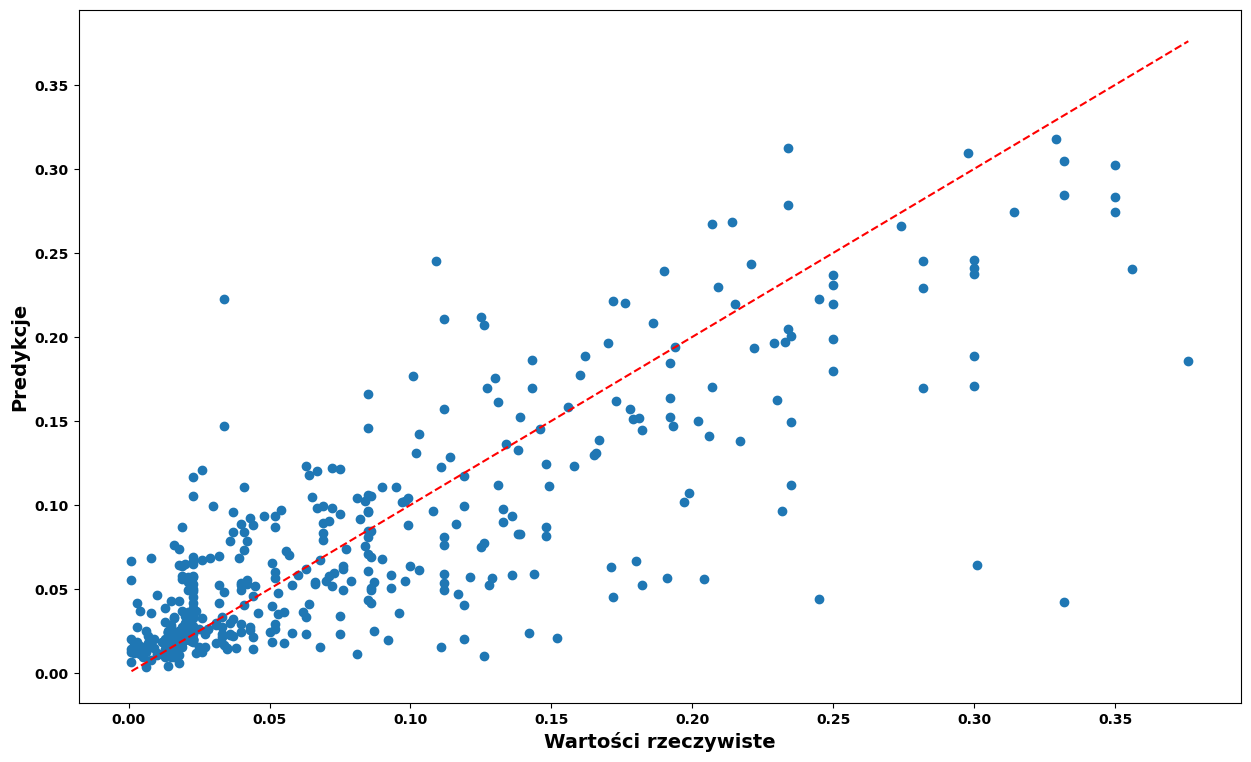

In [11]:
fig, ax = plt.subplots(figsize=(15,9))
plt.scatter(y_test, y_pred)
plt.xlabel('Wartości rzeczywiste', weight='bold', fontsize=14)
plt.ylabel('Predykcje', weight='bold', fontsize=14)
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
# Bold the tick labels on both axes
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
for label in ax.get_yticklabels():
    label.set_fontweight('bold')
plt.show()

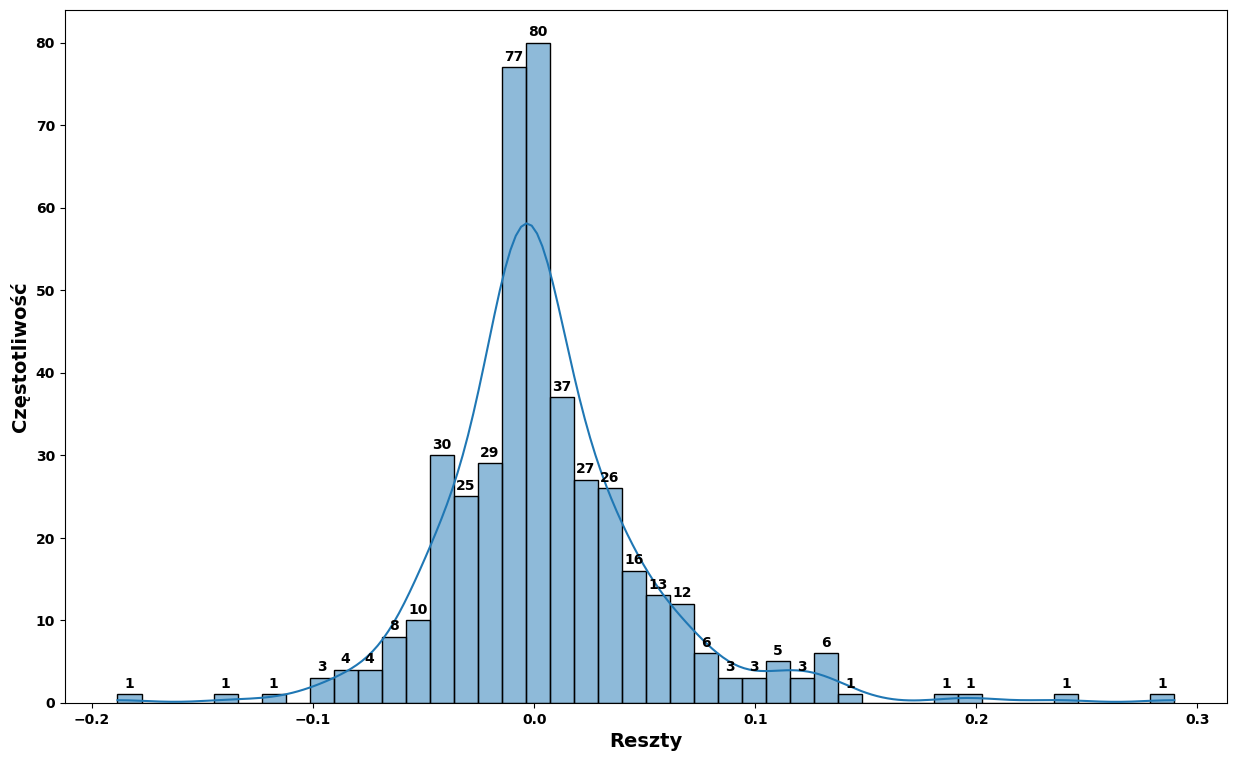

In [12]:
residuals = y_test_series - y_pred

# Create the histogram with default color
fig, ax = plt.subplots(figsize=(15, 9))
hist = sns.histplot(residuals, kde=True)

# Set labels
plt.xlabel('Reszty', weight='bold', fontsize=14)
plt.ylabel('Częstotliwość', weight='bold', fontsize=14)

# Bold the tick labels on both axes
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

# Annotate each bar with its count
for p in hist.patches:
    # Get the height and position of each bar
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2

    # Annotate the bar with its height (count)
    if height > 0:  # To avoid placing annotations for empty bins
        ax.annotate(f'{int(height)}', (x, height), textcoords="offset points", xytext=(0, 5), ha='center', fontweight='bold')

plt.show()

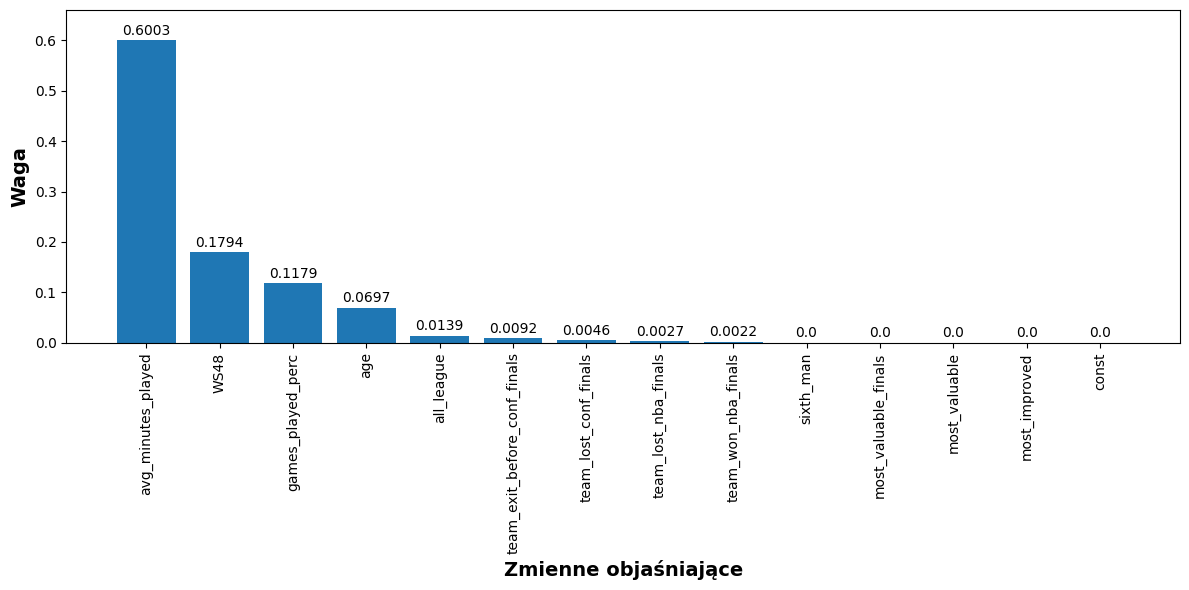

In [13]:
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

X_train_drop = X_train.drop(columns=["ID", "season", "games_started_perc", "minutes_played", "PER"])
# Rearrange feature names so they match the sorted feature importances
names = [X_train_drop.columns[i] for i in indices]

# Create a plot
plt.figure(figsize=(12, 6))

# Create bars
bars = plt.bar(range(len(importances)), importances[indices], align="center")

# Add feature names as x-axis labels
plt.xticks(range(len(importances)), names, rotation=90)

# Create plot title and axis titles
plt.xlabel("Zmienne objaśniające", weight='bold', fontsize=14)
plt.ylabel("Waga", weight='bold', fontsize=14)

# Adjust the y-axis limits: set the upper limit to 1.1 times the highest feature importance
plt.ylim(0, max(importances[indices]) * 1.1)

# Annotate bars with their values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), ha='center', va='bottom')

# Show plot
plt.tight_layout()  # Adjust layout for better visualization if necessary
plt.show()

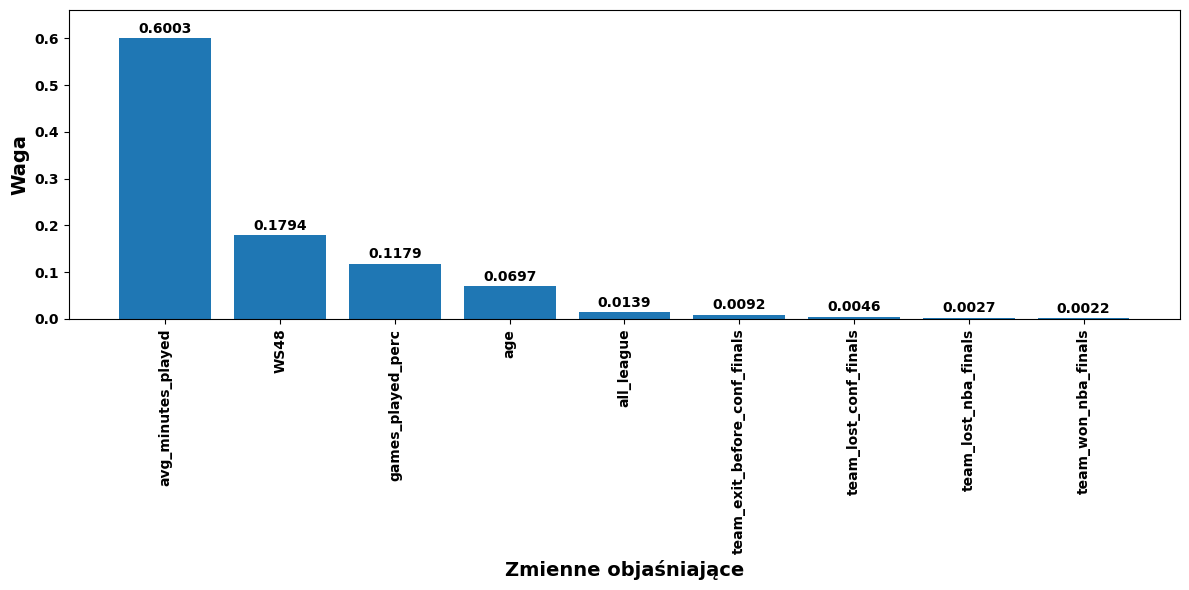

In [14]:
importances = model.feature_importances_

# Sort feature importances in descending order and filter out those with zero importance
indices = np.argsort(importances)[::-1]
non_zero_indices = [index for index in indices if importances[index] > 0.0001]

# Rearrange feature names to match the sorted feature importances and exclude zero importance
names = [X_train_drop.columns[i] for i in non_zero_indices]

# Create a plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for non-zero importances
bars = ax.bar(range(len(non_zero_indices)), importances[non_zero_indices], align="center")

# Add feature names as x-axis labels, tilted by 45 degrees
plt.xticks(range(len(non_zero_indices)), [names[i] for i in range(len(non_zero_indices))], rotation=90)

# Create plot title and axis titles
plt.xlabel("Zmienne objaśniające", weight='bold', fontsize=14)
plt.ylabel("Waga", weight='bold', fontsize=14)

# Adjust the y-axis limits: set the upper limit to 1.1 times the highest feature importance
plt.ylim(0, max(importances[non_zero_indices]) * 1.1)

# Bold the tick labels on both axes
for label in ax.get_xticklabels():
    label.set_fontweight('bold')
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

# Annotate bars with their values in bold
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), ha='center', va='bottom', fontweight='bold')

# Show plot
plt.tight_layout()  # Adjust layout for better visualization if necessary
plt.show()


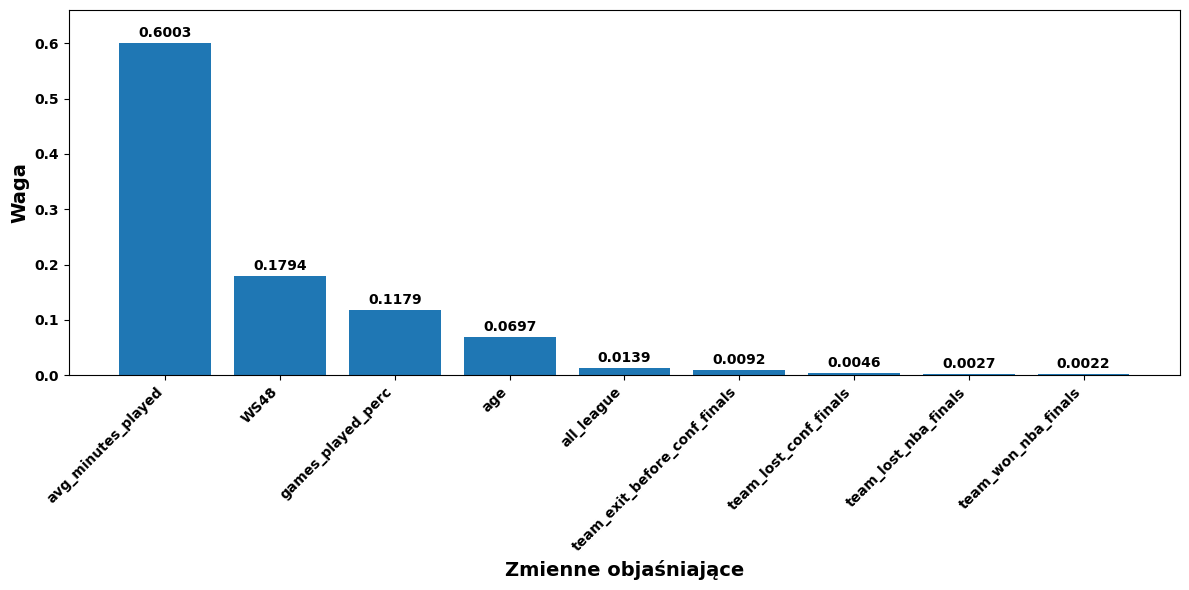

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'importances', 'X_train_drop', and your filtered indices logic is already defined

# Sort feature importances in descending order and filter out those with zero importance
indices = np.argsort(importances)[::-1]
non_zero_indices = [index for index in indices if importances[index] > 0.0001]

# Rearrange feature names to match the sorted feature importances and exclude zero importance
names = [X_train_drop.columns[i] for i in non_zero_indices]

# Create a plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for non-zero importances
bars = ax.bar(range(len(non_zero_indices)), importances[non_zero_indices], align="center")

# Add feature names as x-axis labels, tilted by 45 degrees and right aligned
plt.xticks(range(len(non_zero_indices)), [names[i] for i in range(len(non_zero_indices))], rotation=45, ha="right")

# Create plot title and axis titles
plt.xlabel("Zmienne objaśniające", weight="bold", fontsize=14)
plt.ylabel("Waga", weight="bold", fontsize=14)

# Adjust the y-axis limits: set the upper limit to 1.1 times the highest feature importance
plt.ylim(0, max(importances[non_zero_indices]) * 1.1)

# Bold the tick labels on both axes
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")

# Annotate bars with their values in bold
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, yval + 0.005, round(yval, 4), ha="center", va="bottom", fontweight="bold"
    )

# Show plot
plt.tight_layout()  # Adjust layout for better visualization if necessary
plt.show()

In [ ]:
compare_data = X_test.copy()
compare_data["actual_salary_cap_as_perc"] = y_test
compare_data["predicted_salary_cap_as_perc"] = y_pred
compare_data["difference"] = compare_data["actual_salary_cap_as_perc"] - compare_data["predicted_salary_cap_as_perc"]

In [ ]:
compare_data["actual_salary_cap_as_perc"].describe()

In [ ]:
compare_data["predicted_salary_cap_as_perc"].describe()

In [ ]:
# overvalued
len(compare_data[(compare_data.difference > mae)].index)

In [ ]:
overvalued_df = compare_data[(compare_data['difference'] > mae) & (compare_data['actual_salary_cap_as_perc'] >= 0.05)]
len(overvalued_df)

In [ ]:
# undervalued
len(compare_data[(compare_data.difference < (-1*mae))].index)

In [ ]:
undervalued_df = compare_data[(compare_data['difference'] < (-1*mae)) & (compare_data['actual_salary_cap_as_perc'] >= 0.05)]
len(undervalued_df)

In [ ]:
errors = compare_data[(abs(compare_data["difference"]) > 0.08)]

In [ ]:
len(errors)

In [ ]:
cols_for_drop_comp = ["most_improved", "most_valuable", "sixth_man", "most_valuable_finals", "games_started_perc", "minutes_played", "PER", "const"]

In [ ]:
errors.sort_values(by=['difference'])

In [ ]:
# undervalued
undervalued_xgb = errors.sort_values(by=['difference'])[:5]
undervalued_xgb = undervalued_xgb.drop(columns=cols_for_drop_comp)
undervalued_xgb["games_played_perc"] = undervalued_xgb["games_played_perc"].apply(lambda x: round((x*100), 2))
undervalued_xgb["actual_salary_cap_as_perc"] = undervalued_xgb["actual_salary_cap_as_perc"].apply(lambda x: round((x*100), 2))
undervalued_xgb["predicted_salary_cap_as_perc"] = undervalued_xgb["predicted_salary_cap_as_perc"].apply(lambda x: round((x*100), 2))
undervalued_xgb["difference"] = undervalued_xgb["difference"].apply(lambda x: round((x*-100), 2))
undervalued_xgb.to_csv('./data/final_data/undervalued_xgb.csv', index=False, encoding='utf-8')
undervalued_xgb

In [ ]:
# overvalued
overvalued_xgb = errors.sort_values(by=['difference'])[-5:]
overvalued_xgb = overvalued_xgb.drop(columns=cols_for_drop_comp)
overvalued_xgb = overvalued_xgb.sort_values(by=['difference'], ascending=False)
overvalued_xgb["games_played_perc"] = overvalued_xgb["games_played_perc"].apply(lambda x: round((x*100), 2))
overvalued_xgb["actual_salary_cap_as_perc"] = overvalued_xgb["actual_salary_cap_as_perc"].apply(lambda x: round((x*100), 2))
overvalued_xgb["predicted_salary_cap_as_perc"] = overvalued_xgb["predicted_salary_cap_as_perc"].apply(lambda x: round((x*100), 2))
overvalued_xgb["difference"] = overvalued_xgb["difference"].apply(lambda x: round((x*100), 2))
overvalued_xgb.to_csv('./data/final_data/overvalued_xgb.csv', index=False, encoding='utf-8')
overvalued_xgb